### **SmolDocling-256M-preview - Multimodal**

*demo notebook by : [prithivMLmods 🤗x❤️](https://huggingface.co/prithivMLmods)*

In [ ]:
%%capture
!pip install git+https://github.com/huggingface/transformers.git \
             git+https://github.com/huggingface/accelerate.git \
             git+https://github.com/huggingface/peft.git \
             transformers-stream-generator huggingface_hub albumentations \
             pyvips-binary qwen-vl-utils sentencepiece opencv-python docling-core \
             python-docx torchvision safetensors matplotlib num2words \

!pip install xformers requests pymupdf hf_xet spaces pyvips pillow gradio \
             einops torch fpdf timm av

**Run App**

In [ ]:
import os
import random
import uuid
import json
import time
import asyncio
from threading import Thread

import gradio as gr
import spaces
import torch
from PIL import Image, ImageOps

from transformers import (
    AutoModelForVision2Seq,
    AutoProcessor,
    TextIteratorStreamer,
)
from transformers.image_utils import load_image

from docling_core.types.doc import DoclingDocument, DocTagsDocument

import re
import ast
import html

# Constants for text generation
MAX_MAX_NEW_TOKENS = 5120
DEFAULT_MAX_NEW_TOKENS = 3072
MAX_INPUT_TOKEN_LENGTH = int(os.getenv("MAX_INPUT_TOKEN_LENGTH", "4096"))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load SmolDocling-256M-preview
MODEL_ID_X = "ds4sd/SmolDocling-256M-preview"
processor = AutoProcessor.from_pretrained(MODEL_ID_X, trust_remote_code=True)
model = AutoModelForVision2Seq.from_pretrained(
    MODEL_ID_X,
    trust_remote_code=True,
    dtype=torch.float16
).to(device).eval()

# Preprocessing functions for SmolDocling-256M
def add_random_padding(image, min_percent=0.1, max_percent=0.10):
    """Add random padding to an image based on its size."""
    image = image.convert("RGB")
    width, height = image.size
    pad_w_percent = random.uniform(min_percent, max_percent)
    pad_h_percent = random.uniform(min_percent, max_percent)
    pad_w = int(width * pad_w_percent)
    pad_h = int(height * pad_h_percent)
    corner_pixel = image.getpixel((0, 0))  # Top-left corner
    padded_image = ImageOps.expand(image, border=(pad_w, pad_h, pad_w, pad_h), fill=corner_pixel)
    return padded_image

def normalize_values(text, target_max=500):
    """Normalize numerical values in text to a target maximum."""
    def normalize_list(values):
        max_value = max(values) if values else 1
        return [round((v / max_value) * target_max) for v in values]

    def process_match(match):
        num_list = ast.literal_eval(match.group(0))
        normalized = normalize_list(num_list)
        return "".join([f"<loc_{num}>" for num in normalized])

    pattern = r"\[([\d\.\s,]+)\]"
    normalized_text = re.sub(pattern, process_match, text)
    return normalized_text

@spaces.GPU
def generate_image(text: str, image: Image.Image,
                   max_new_tokens: int = 1024,
                   temperature: float = 0.6,
                   top_p: float = 0.9,
                   top_k: int = 50,
                   repetition_penalty: float = 1.2):
    """Generate responses for image input using the SmolDocling model."""
    if image is None:
        yield "Please upload an image.", "Please upload an image."
        return

    images = [image]

    # Preprocessing specific to SmolDocling
    if "OTSL" in text or "code" in text:
        images = [add_random_padding(img) for img in images]
    if "OCR at text at" in text or "Identify element" in text or "formula" in text:
        text = normalize_values(text, target_max=500)

    messages = [
        {
            "role": "user",
            "content": [{"type": "image"} for _ in images] + [
                {"type": "text", "text": text}
            ]
        }
    ]
    prompt = processor.apply_chat_template(messages, add_generation_prompt=True)
    inputs = processor(text=prompt, images=images, return_tensors="pt").to(device)

    streamer = TextIteratorStreamer(processor, skip_prompt=True, skip_special_tokens=True)
    generation_kwargs = {
        **inputs,
        "streamer": streamer,
        "max_new_tokens": max_new_tokens,
        "temperature": temperature,
        "top_p": top_p,
        "top_k": top_k,
        "repetition_penalty": repetition_penalty,
    }
    thread = Thread(target=model.generate, kwargs=generation_kwargs)
    thread.start()

    buffer = ""
    for new_text in streamer:
        buffer += new_text.replace("<|im_end|>", "")
        yield buffer, buffer

    # Post-processing specific to SmolDocling
    cleaned_output = buffer.replace("<end_of_utterance>", "").strip()
    if any(tag in cleaned_output for tag in ["<doctag>", "<otsl>", "<code>", "<chart>", "<formula>"]):
        if "<chart>" in cleaned_output:
            cleaned_output = cleaned_output.replace("<chart>", "<otsl>").replace("</chart>", "</otsl>")
            cleaned_output = re.sub(r'(<loc_500>)(?!.*<loc_500>)<[^>]+>', r'\1', cleaned_output)
        doctags_doc = DocTagsDocument.from_doctags_and_image_pairs([cleaned_output], images)
        doc = DoclingDocument.load_from_doctags(doctags_doc, document_name="Document")
        markdown_output = doc.export_to_markdown()
        yield buffer, markdown_output
    else:
        yield buffer, cleaned_output

# CSS for styling the interface
css = """
.submit-btn {
    background-color: #2980b9 !important;
    color: white !important;
}
.submit-btn:hover {
    background-color: #3498db !important;
}
.canvas-output {
    border: 2px solid #4682B4;
    border-radius: 10px;
    padding: 20px;
}
"""

# Create the Gradio Interface
with gr.Blocks(css=css, theme="bethecloud/storj_theme") as demo:
    gr.Markdown("# **[Image OCR with SmolDocling](https://huggingface.co/ds4sd/SmolDocling-256M-preview)**")
    with gr.Row():
        with gr.Column():
            gr.Markdown("### Image Inference")
            image_query = gr.Textbox(label="Query Input", placeholder="Enter your query here...")
            image_upload = gr.Image(type="pil", label="Image")
            image_submit = gr.Button("Submit", elem_classes="submit-btn")

            with gr.Accordion("Advanced options", open=False):
                max_new_tokens = gr.Slider(label="Max new tokens", minimum=1, maximum=MAX_MAX_NEW_TOKENS, step=1, value=DEFAULT_MAX_NEW_TOKENS)
                temperature = gr.Slider(label="Temperature", minimum=0.1, maximum=4.0, step=0.1, value=0.6)
                top_p = gr.Slider(label="Top-p (nucleus sampling)", minimum=0.05, maximum=1.0, step=0.05, value=0.9)
                top_k = gr.Slider(label="Top-k", minimum=1, maximum=1000, step=1, value=50)
                repetition_penalty = gr.Slider(label="Repetition penalty", minimum=1.0, maximum=2.0, step=0.05, value=1.2)

        with gr.Column():
            with gr.Column(elem_classes="canvas-output"):
                gr.Markdown("## Output")
                raw_output = gr.Textbox(label="Raw Output Stream", interactive=False, lines=5)

                with gr.Accordion("Formatted Result (Markdown)", open=False):
                    formatted_output = gr.Markdown(label="Result.md")

            gr.Markdown("> **[SmolDocling-256M-preview](https://huggingface.co/ds4sd/SmolDocling-256M-preview)**: SmolDocling is a multimodal Image-Text-to-Text model designed for efficient document conversion. It retains Docling's most popular features while ensuring full compatibility with Docling through seamless support for DoclingDocuments.")

    image_submit.click(
        fn=generate_image,
        inputs=[image_query, image_upload, max_new_tokens, temperature, top_p, top_k, repetition_penalty],
        outputs=[raw_output, formatted_output]
    )

if __name__ == "__main__":
    demo.queue(max_size=50).launch(share=True, show_error=True)

### **Demo Inference Screenshot**

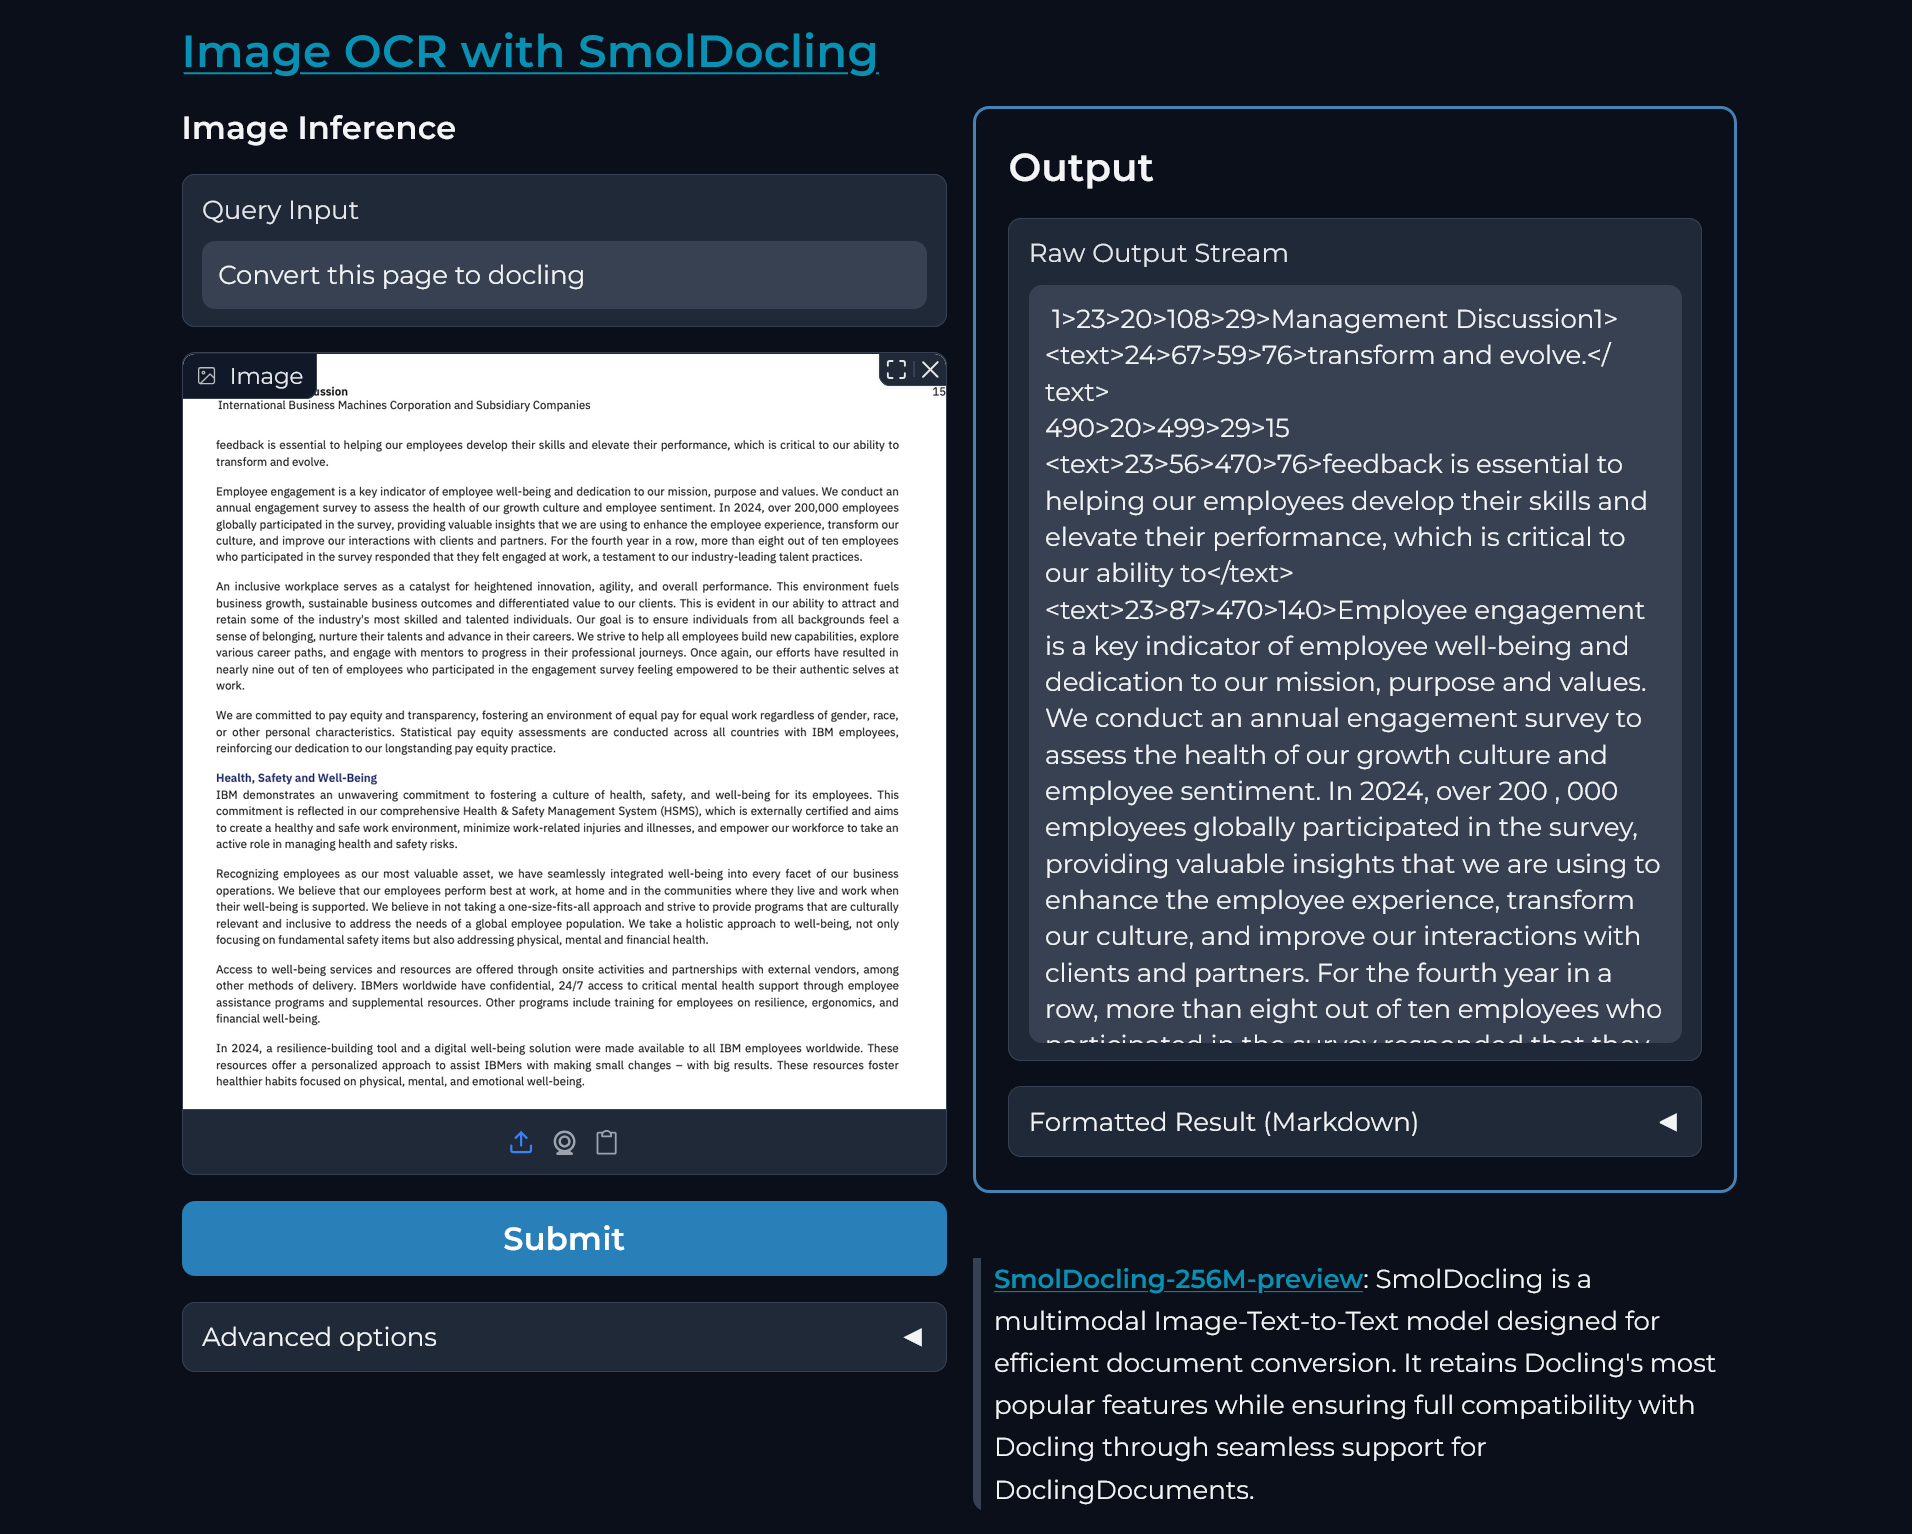